## Exercice 1

In [1]:
import json 
import matplotlib.pyplot as plt
import urllib
import pandas as pd 
import numpy as np
import operator
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_curve, auc
import seaborn as sns

In [2]:
# Reading training_set file 
with open('training_set.json', encoding="utf8") as json_file:
    training_data = json.load(json_file)
    
# Reading testing_set file 
with open('testing_set.json', encoding="utf8") as json_file:
    testing_data = json.load(json_file)

In [3]:
# Loading training data 
df_train = pd.read_json("training_set.json")

# Loading test data
df_test = pd.read_json("testing_set.json")

In [4]:
# Separating the feature (sentence) and the target (intent)
x_train = df_train['sentence'].to_numpy()
y_train = df_train['intent'].to_numpy()

x_test = df_test['sentence'].to_numpy()
y_test = df_test['intent'].to_numpy()

In [5]:
# Function that returns the sentence's intention (max probability)
def prediction(sentence) :
    url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(sentence) +">"
    requete = urllib.request.urlopen(url)
    result_requete = json.load(requete)
    # Only focuses on the max index 
    prediction_result = max(result_requete.items(), key=operator.itemgetter(1))[0]
    return prediction_result

# Function that returns the probability of each class
def prediction_vect(sentence) :
    url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(sentence) +">"
    requete = urllib.request.urlopen(url)
    result_requete = json.load(requete)
    # Only focuses on the max index 
    prediction_result = list(result_requete.values())
    return prediction_result

In [6]:
# Function that predicts intentions on all the test set and returns one intention
def predictionMaxProba(test_set) :
    y_prediction = []
    for i in range(len(test_set)):
        y_prediction.append(prediction(test_set[i]))
    return y_prediction 

# Prediction on test set (max probability)
y_prediction = predictionMaxProba(x_test)

# Function that predicts intentions on all the test set and returns each class's probability
def predictionProba(test_set) :
    y_prediction_vect = []
    for i in range(len(test_set)):
        y_prediction_vect.append(prediction_vect(test_set[i]))
    y_prediction_vect = np.array(y_prediction_vect)
    return y_prediction_vect

# Prediction on test set (probabilty of each class)
y_prediction_vect = predictionProba(x_test)

###  Analyse du jeu de données

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6035 entries, 0 to 6034
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    6035 non-null   object
 1   sentence  6035 non-null   object
dtypes: object(2)
memory usage: 94.4+ KB


In [8]:
df_train.describe()

,intent,sentence
count,6035,6035
unique,8,6035
top,irrelevant,Comment cela se passe t il si on passe par toi...
freq,3852,1


In [9]:
df_train.groupby('intent').count()

,sentence
intent,
find-around-me,383
find-flight,142
find-hotel,316
find-restaurant,469
find-train,143
irrelevant,3852
provide-showtimes,117
purchase,613


#### Remarques : Les données d'entraînement ne semblent pas contenir de données nulles. Cette base est constituée de 8 classes et d'un total de 6035 données. La classe majoritaire est la classe 'irrelevant' et contient plus de 3800 données ce qui représente plus de la moitié de jeu de données d'entraînement. Le reste des classes contiennent très peu de données ce qui signifie un grand déséquilibre de ce jeu de données. On peut s'attendre à ce que cela influence les prédictions du modèle. 


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    1065 non-null   object
 1   sentence  1065 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


In [11]:
df_test.describe()

,intent,sentence
count,1065,1065
unique,8,1064
top,irrelevant,Est ce que tu connais des sites internet sur l...
freq,677,2


In [12]:
df_test.groupby('intent').count()

,sentence
intent,
find-around-me,67
find-flight,24
find-hotel,55
find-restaurant,93
find-train,21
irrelevant,677
provide-showtimes,14
purchase,114


#### Remarques : Le jeu de données de test contient 1065 données et ne contient pas non plus de données nulles. Tout comme pour le jeu d'entraînement, la classe 'irrelevant' est majoritaire et contient encore une fois plus de la moitié des données de test. Il faudra donc prêter attention aux métriques que l'on va utiliser pour évaluer les performances de ce modèle.

### Métriques de classification

In [13]:
# Comparison between y_prediction (prediction on x_test) and the actual results (y-test)
accuracy = accuracy_score(y_test, y_prediction)
print("Accuracy : " + str(accuracy))

Accuracy : 0.8093896713615023


##### Remarques :  A première vue, on pourrait penser que le modèle est plutôt fiable car il a une bonne justesse. Il faudrait cependant garder en tête que la base de données est fortement déséquilibrée.

In [14]:
balanced_accuracy = balanced_accuracy_score(y_test, y_prediction)
print("Balanced accuracy score : " + str(balanced_accuracy))

Balanced accuracy score : 0.5270967720223785


##### Remarques : La 'balanced accuracy score' calculera la justesse du modèle en prenant en considération le déséquilibre de la base de données sur laquelle il a été entraîné. On peut en conclure que le modèle sera bon pour reconnaître les données correspondantes à la classe 'irrelevant' qui est la classe majoritaire mais beaucoup moins bon pour reconnaître les autres classes.

In [15]:
print(classification_report(y_test, y_prediction))

                   precision    recall  f1-score   support

   find-around-me       0.86      0.37      0.52        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.76      0.40      0.52        55
  find-restaurant       0.90      0.66      0.76        93
       find-train       0.93      0.67      0.78        21
       irrelevant       0.80      0.98      0.88       677
provide-showtimes       0.80      0.29      0.42        14
         purchase       0.82      0.56      0.67       114

         accuracy                           0.81      1065
        macro avg       0.84      0.53      0.62      1065
     weighted avg       0.82      0.81      0.79      1065



##### Remarques : On remarque qu'on a une précision qui est assez haute (et cela pour toutes les classes sauf la classe majoritaire 'irrelevant') tandis que le rappel est plutôt bas. Cela signifie que pour toutes les classes hormi la classe majoritaire, quand il s'agit en effet (par exemple) de la 'classe1' il n'est pas toujours capable de la classer en tant que 'classe1'. Mais quand il classe un élément dans la 'classe1', il s'agit en effet d'un élément de cette classe. 
##### Il n'y a que pour la classe 'irrelevant' que l'on voit une haute précision et un haut rappel, mais le rappel est supérieur à la précision. Cela signifie que le modèle classe plusieurs éléments comme étant 'irrelevant', qu'ils le soient ou non.

In [16]:
def plot_cm(y_true, y_pred, cmap, xticks_rotation, normalize):
    # Categories
    labels = ['find-around-me','find-flight','find-hotel', 'find-restaurant', 'find-train',  'irrelevant', 'provide-showtimes', 'purchase']
    # y_true and y_pred are OneHotEncoded, confusion_matrix takes a list of predictions !
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    if normalize == 'true': 
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            cm[i,j] = format(cm[i, j], '.2f')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap, ax=None, xticks_rotation='horizontal')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=12)
    plt.yticks(tick_marks, labels, fontsize=12)

C:\Users\hibsb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass include_values=viridis as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


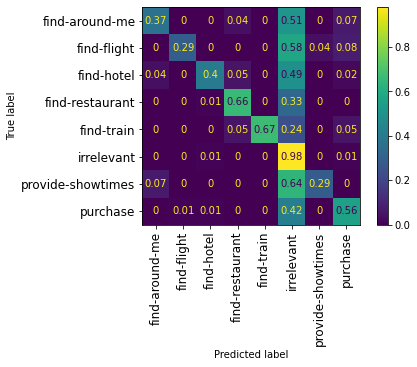

In [17]:
# Plot confusion matrix
plot_cm(y_test, y_prediction, 'viridis', 'horizontal', 'true')

##### Remarques : On peut déduire de cette matrice de confusion que le modèle classe la majorité des données comme étant 'irrelevant'. Lorsqu'il fait une prédiction, soit il prédit la bonne classe soit il prédit la classe majoritaire. Cela explique les résultats de rappel et précision obtenus précédemment. 

In [18]:
# ROC Score requires OneHotEncoded vector 
x = [['find-around-me'], ['find-flight'], ['find-hotel'], ['find-restaurant'], ['find-train'], ['irrelevant'], ['provide-showtimes'], ['purchase']]
encoder = OneHotEncoder().fit(x)
y_test_encoded = encoder.transform(y_test.reshape(-1,1)).toarray()

In [19]:
# ROC Score 
roc_auc_score(y_test_encoded, y_prediction_vect)

0.5688356888514263

##### Remarques : On a un ROC_AUC_Score plutôt bas, ce qui signifie que le modèle n'est pas capable de bien distinguer entre les classes.

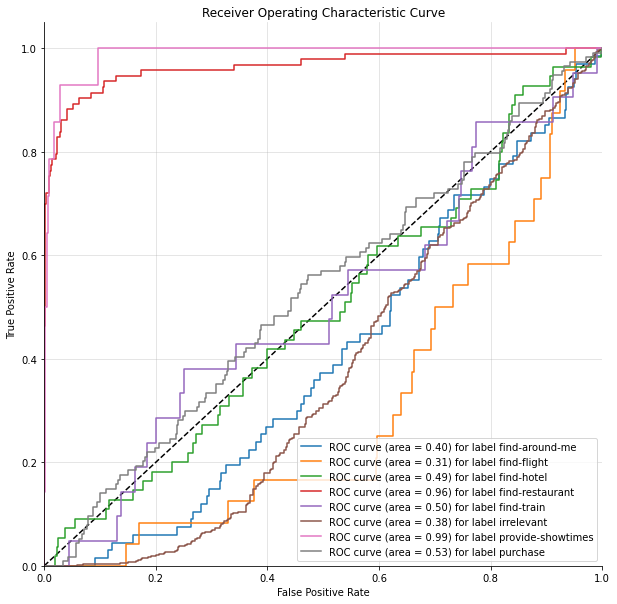

In [20]:
# Compute ROC curve for each class
labels = ['find-around-me','find-flight','find-hotel', 'find-restaurant', 'find-train',  'irrelevant', 'provide-showtimes', 'purchase']
n_classes = len(labels)
fpr = [0 for i in range(n_classes)]
tpr = [0 for i in range(n_classes)]
roc_auc = [0 for i in range(n_classes)]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_prediction_vect[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for all classes
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

##### Remarques :  On peut dire que le modèle est bon si l'aire sous la courbe est maximale. Or, ce n'est pas toujours le cas ici. Les classes find-restaurant et provide-showtimes ont un bon ROC_AUC_Score, ce qui signifie que les utérances appartenant à ces classes sont bien prédits.
##### Par contre, pour les autres classes, il y a plus de faux positifs que de vrais positifs. Le modèle ne prédit pas bien ces classes.

#### Remarques : Les données d'entraînement ne semblent pas contenir de données nulles. Cette base est constituée de 8 classes et d'un total de 6035 données. La classe majoritaire est la classe 'irrelevant' et contient plus de 3800 données ce qui représente plus de la moitié de jeu de données d'entraînement. Le reste des classes contiennent très peu de données ce qui signifie un grand déséquilibre de ce jeu de données. On peut s'attendre à ce que cela influence les prédictions du modèle. 


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    1065 non-null   object
 1   sentence  1065 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


In [22]:
df_test.describe()

,intent,sentence
count,1065,1065
unique,8,1064
top,irrelevant,Est ce que tu connais des sites internet sur l...
freq,677,2


In [23]:
df_test.groupby('intent').count()

,sentence
intent,
find-around-me,67
find-flight,24
find-hotel,55
find-restaurant,93
find-train,21
irrelevant,677
provide-showtimes,14
purchase,114


##### Réponse / idées : 
Seuil de classification 

In [24]:
# Function that returns the sentence's intention and its probability
def predictionScore(features) :
    y_prediction = []
    y_score = []
    for sentence in features:
        url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(sentence) +">"
        requete = urllib.request.urlopen(url)
        result_requete = json.load(requete)
        
        # Only focuses on the max index 
        prediction_result = max(result_requete.items(), key=operator.itemgetter(1))[0]
        prediction_score = max(result_requete.items(), key=operator.itemgetter(1))[1]
        
        y_prediction.append(prediction_result)
        y_score.append(prediction_score)
        
    df_prediction_score = pd.DataFrame({'Intention':y_prediction, 'Scores':y_score})
    
    return df_prediction_score


# Function that returns the probability of the ground truth
def groundTruthScore(features, intentions) :
    y_intention = []
    y_score = []
    
    for i in range(len(features)):
        url = "http://localhost:8080/api/intent?sentence=<" + urllib.parse.quote(features[i]) +">"
        requete = urllib.request.urlopen(url)
        result_requete = json.load(requete)
        
        y_intention.append(intentions[i])
        y_score.append(result_requete[intentions[i]])
        
    df_ground_truth_score = pd.DataFrame({'Intention':y_intention, 'Scores':y_score})
    
    return df_ground_truth_score

In [25]:
# Function that computes means and standard deviation
def mean_std_score_label(scores):
    labels = ['find-around-me','find-flight','find-hotel', 'find-restaurant', 'find-train',  'irrelevant', 'provide-showtimes', 'purchase']
    
    mean = []
    std = []
    for label in labels:
        mean_label = scores.loc[scores['Intention'].isin([label]), 'Scores'].mean()
        std_label = scores.loc[scores['Intention'].isin([label]), 'Scores'].std()
        
        mean.append(mean_label)
        std.append(std_label)
    
    
    mean_scores = pd.DataFrame({'Label':labels, 'Mean':mean, 'Standard deviation':std})
    
    return mean_scores

In [26]:
ground_truth_score = groundTruthScore(x_test, y_test)
print("Ground Truth :\n")
mean_std_ground_truth = mean_std_score_label(ground_truth_score)
print(mean_std_ground_truth)

print("\n\n")
prediction_score = predictionScore(x_test)
print("Prediction :\n")
mean_std_prediction = mean_std_score_label(prediction_score)
print(mean_std_prediction)

Ground Truth :

               Label      Mean  Standard deviation
0     find-around-me  0.302347            0.228291
1        find-flight  0.285899            0.220907
2         find-hotel  0.346231            0.265381
3    find-restaurant  0.508404            0.256457
4         find-train  0.458524            0.296442
5         irrelevant  0.717477            0.180213
6  provide-showtimes  0.249688            0.197148
7           purchase  0.433410            0.239385



Prediction :

               Label      Mean  Standard deviation
0     find-around-me  0.520302            0.170593
1        find-flight  0.514546            0.197866
2         find-hotel  0.628303            0.176036
3    find-restaurant  0.623600            0.191023
4         find-train  0.631442            0.163368
5         irrelevant  0.689272            0.183049
6  provide-showtimes  0.491745            0.149602
7           purchase  0.571429            0.180522


##### Remarque : On constate que la moyenne pour le score de chaque classe est différente pour les vraies intentions et pour les intentions prédites par le modèle. Ainsi, afin de pouvoir mieux prédire les classes, on aurait tendance à vouloir fixer un seuil par classe, qui serait égal à la moyenne de score calculée pour chaque classe. Or, on constate que l'écart-type est trop élevé pour faire cela. En effet, il faudrait un écart-type insignifiant pour pouvoir fixer la moyenne de chaque classe comme seuil pour chaque classe. En effet, un écart-type insignifiant signifierait que les scores ne varient pas beaucoup.

##### Sinon, on pourrait vouloir, fixer le score minimum obtenu pour chaque vraie intention, mais

## Exercice 3

In [46]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import texthero as hero
from transformers import pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hibsb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hibsb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hibsb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Fonction de prétraitement du langage

In [28]:
def punctuation(text):
    text = text.replace(",", " ")
    text = text.replace(":", " ")
    text = text.replace(".", " ")
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    text = text.replace("|", " ")
    text = text.replace("&", " ")
    text = text.replace('"', " ")
    text = text.replace("'", " ")
    text = text.replace(">", " ")
    return text


def abbreviation(text):
    text = text.replace("j'", "je ")
    text = text.replace("n'", "ne ")
    text = text.replace("t'", "te ")
    text = text.replace("m'", "me ")
    text = text.replace("\n", " ")
    return text


def stopwords_remove(text, language='french'):
    lang_stopwords = set(stopwords.words(language))
    token = [token for token in text.lower().split(" ") if token != " " if token not in lang_stopwords]
    text = " ".join(["".join(token) for token in token])
    return text


def preprocessing(text, lex_analysis_method= None):
    # Simple text standardisation
    text = text.lower()
    text = abbreviation(text)
    text = punctuation(text)
    text = stopwords_remove(text)
    # Performing lexical analysis
    if lex_analysis_method != 'stem':
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(x) for x in nltk.word_tokenize(text)])
    elif lex_analysis_method == 'stem':
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(x) for x in nltk.word_tokenize(text)])
    else :
        return text
    return text

### Oversampling 

In [30]:
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x_train.reshape(-1, 1), y_train)

### Entraînement du modèle

In [32]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=42)),
               ])
sgd.fit(x_over[:,0], y_over)

y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8413145539906103
                   precision    recall  f1-score   support

   find-around-me       0.62      0.78      0.69        67
      find-flight       0.81      0.92      0.86        24
       find-hotel       0.60      0.89      0.72        55
  find-restaurant       0.72      0.94      0.81        93
       find-train       0.66      0.90      0.76        21
       irrelevant       0.96      0.82      0.88       677
provide-showtimes       0.76      0.93      0.84        14
         purchase       0.78      0.89      0.83       114

         accuracy                           0.84      1065
        macro avg       0.74      0.88      0.80      1065
     weighted avg       0.87      0.84      0.85      1065



In [33]:
balanced_accuracy_over = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy score : " + str(balanced_accuracy_over))

Balanced accuracy score : 0.8828263872076763


### Texthero

In [35]:
nlp = pipeline('fill-mask', model="camembert-base")
nlp('<mask> mange du chocolat')

Some weights of CamembertForMaskedLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'sequence': '<s> Je mange du chocolat</s>',
  'score': 0.41783902049064636,
  'token': 100,
  'token_str': '▁Je'},
 {'sequence': '<s> je mange du chocolat</s>',
  'score': 0.14882291853427887,
  'token': 50,
  'token_str': '▁je'},
 {'sequence': '<s> On mange du chocolat</s>',
  'score': 0.04208674281835556,
  'token': 201,
  'token_str': '▁On'},
 {'sequence': '<s> Elle mange du chocolat</s>',
  'score': 0.036471009254455566,
  'token': 195,
  'token_str': '▁Elle'},
 {'sequence': '<s> Maman mange du chocolat</s>',
  'score': 0.026984261348843575,
  'token': 12101,
  'token_str': '▁Maman'}]

#### Ce qu'on veut faire :
#### 1. preprocesser les phrases de toutes la base de données 
#### 2. enlever les données de la bdd qui sont vides ([])
#### 3. remplacer certains mots pertinents dans la phrase grâce au nlp fill-mask

In [36]:
df = df_train
df['new'] = [preprocessing(x) for x in df["sentence"]]
df['new2'] = [x.split() for x in df['new']]
df['new2'] = df['new2'].replace([], np.nan)
df['new2'] = df['new2'].dropna()
#nlp(df["new"][0].split()[3] + df["new"][0].split()[4])
df['new3'] = [" ".join(x).replace(x[0]," <mask> ", 1) if len(x)>0 else np.nan for x in df['new2']]

In [37]:
df['new3']

0        <mask>  maximum loyer partir janvier si possible
1                                                 <mask> 
2        <mask>  cabriolet hybrid moins 5m10 minimum 4...
3                    <mask>  cher location vacances corse
4                                 <mask>  utiliser nuit ?
                              ...                        
6030     <mask>  suggestion hôtel 4 * prague - budget ...
6031                            <mask>  bien dirais pense
6032                                      <mask>  dilemme
6033                                     <mask>  triste ?
6034     <mask>  loin limite budget cuisine traditionn...
Name: new3, Length: 6035, dtype: object

In [38]:
df['new4'] = [nlp(x) if x != np.nan else np.nan for x in df["new5"]] 
df['new4']

KeyError: 'new5'

In [39]:
df['new5'] = [type(x) for x in df["new3"]]
df['new5']

0       <class 'str'>
1       <class 'str'>
2       <class 'str'>
3       <class 'str'>
4       <class 'str'>
            ...      
6030    <class 'str'>
6031    <class 'str'>
6032    <class 'str'>
6033    <class 'str'>
6034    <class 'str'>
Name: new5, Length: 6035, dtype: object

In [41]:
df["new5"][df["new5"]!=str].count()

6

In [42]:
df["new5"][df["new5"]!=list].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034],
           dtype='int64', length=6035)

In [43]:
df["new5"] = df["new5"].drop(df["new5"][df["new5"]!=str].index)

In [44]:
df["new5"][df["new5"]!=list].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034],
           dtype='int64', length=6035)

In [45]:
df["new5"][df["new5"]!=str].count()

0

## Exercice 4

##### Réponse / idées : 

## Exercice 5

##### Réponse / idées : 